# Выбор локации для скважины

# Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Для решения данной задачи предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Анализ, расчет возможной прибыли и рисков будет выполнен техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

Импортируем библиотеки:

In [1]:
!pip install scikit-learn==1.5.0 -q

import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

RANDOM_STATE=42

## Загрузка и подготовка данных

### Загрузка данных, изучение информации

Загружаем данные и сохраняем в датареймы:

In [2]:
#Датафрейм с данными по региону 1
df_zone_1 = pd.read_csv('/datasets/geo_data_0.csv')

# Датафрейм с данными по региону 2
df_zone_2 = pd.read_csv('/datasets/geo_data_1.csv')

#Датафрейм с данными по региону 3
df_zone_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
print('Датафрейм df_zone_1 с данными геологоразведки региона 1:')
display(df_zone_1.sample(5))
df_zone_1.info()

Датафрейм df_zone_1 с данными геологоразведки региона 1:


,id,f0,f1,f2,product
92672,O7Rmx,-0.956482,0.065876,4.162163,121.738347
85347,X6rzn,1.117712,-0.444153,0.960750,70.720959
99407,wzU8V,0.328766,-0.208776,2.782155,115.628944
11654,9SXhU,1.613953,-0.408510,3.228399,160.353486
87475,Bk1de,0.858201,0.341729,1.303221,28.936811


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
print('Датафрейм df_zone_2 с данными геологоразведки региона 2:')
display(df_zone_2.sample(5))
df_zone_2.info()

Датафрейм df_zone_2 с данными геологоразведки региона 2:


,id,f0,f1,f2,product
29509,dVsQV,-16.290469,0.648358,3.994329,110.992147
59211,HGroF,-5.340052,-6.379315,5.011864,137.945408
89007,QMc81,12.200232,-5.851330,5.002231,134.766305
64247,ilAvu,5.114822,-7.104476,3.996774,107.813044
17668,uTVDn,4.089590,2.247265,3.001235,80.859783


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
print('Датафрейм df_zone_3 с данными геологоразведки региона 3:')
display(df_zone_3.sample(5))
df_zone_3.info()

Датафрейм df_zone_3 с данными геологоразведки региона 3:


,id,f0,f1,f2,product
20391,YqfOq,-4.440356,3.333104,4.078917,108.113237
80825,ICWeu,-1.550530,-1.064870,2.713230,43.461829
21116,jHapY,2.632587,-1.824556,5.306297,160.990839
75444,631wT,-3.467312,-0.928820,0.487370,108.322402
33174,6sFIn,1.520712,-0.249263,-0.261840,30.828109


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Описание данных**:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Вывод**: 

В каждом из трех датафреймов:

- по 10000 строк и 5 столбцов;
- пропусков нет;
- названия столбцов записаны корректно, исправлений не требуется;
- типы данных верные.

Данные представлены хорошего качества.

###  Предобработка данных

**Проверка наличия явных дубликатов**

In [6]:
# список датафреймов
dfs=[
    df_zone_1,
    df_zone_2,
    df_zone_3,
]

# с помощью цикла проверяем на дубликаты каждый датафрейм
for df in dfs:
    print(f'''Количество явных дубликатов: 
    {df.duplicated().sum()}
    ''')

Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    


**Вывод:** явных дубликатов не выявлено.

**Проверка наличия неявных дубликатов**

Уберем из датафреймов 'id' и проверим на дубликаты:

In [7]:
# с помощью цикла проверяем на неявные дубликаты каждый датафрейм
for df in dfs:
    print(f'''Количество явных дубликатов: 
    {df.drop(columns='id').duplicated().sum()}
    ''')

Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    


**Вывод:** неявных дубликатов не выявлено.

**Вывод:** На этапе предобработки данных было выполнено:
- проверка на явные дубликаты;
- проверка на неявные дубликаты.

Не выявлено.

### Анализ данных

Определим число "бинов" для данных датафреймов по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 100000 наблюдений, получаем bins = 18.

In [8]:
# функция для визуализации данных
def explorer(data):
    print('Статистический анализ:')
    display(data.describe())
    print('Гистограммы:')
    data.hist(figsize=(15, 10), bins=18, edgecolor='black', color = 'teal')
    plt.show()
    corr_matrix = data.corr()
    print('Матрица корреляции:')
    display(corr_matrix)
    print('Тепловая карта:')
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

Посмотрим на **датафрейм df_zone_1** с данными геологоразведки региона 1:

Статистический анализ:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Гистограммы:


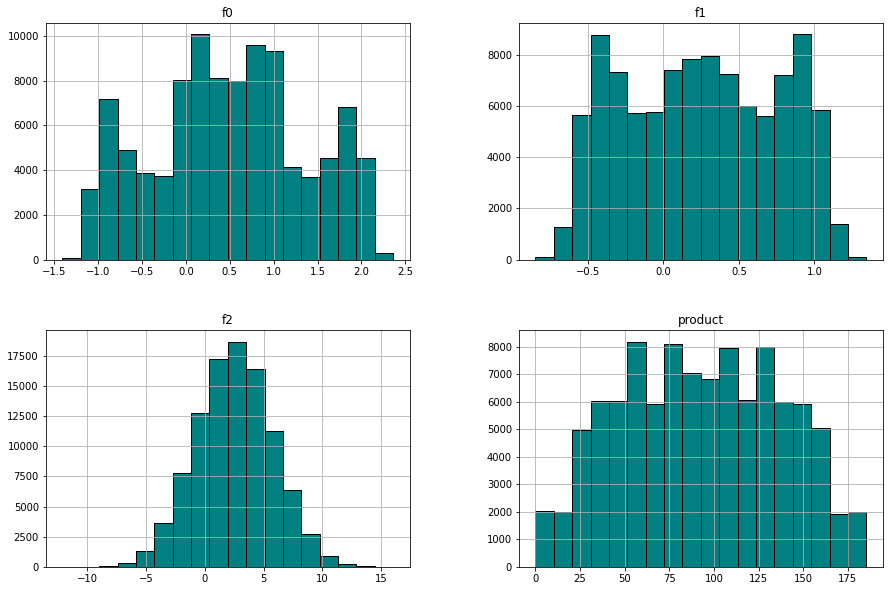

Матрица корреляции:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Тепловая карта:


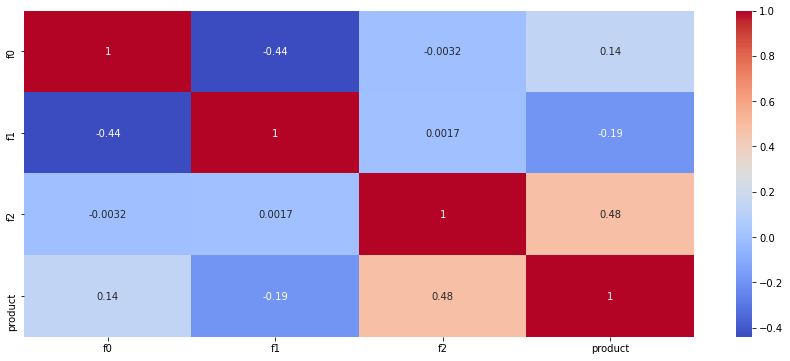

In [9]:
explorer(df_zone_1)

**Вывод**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется связь между признаками прямая и обратная. Мультиколлинеарности нет.

Посмотрим на **датафрейм df_zone_2** с данными геологоразведки региона 2:

Статистический анализ:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Гистограммы:


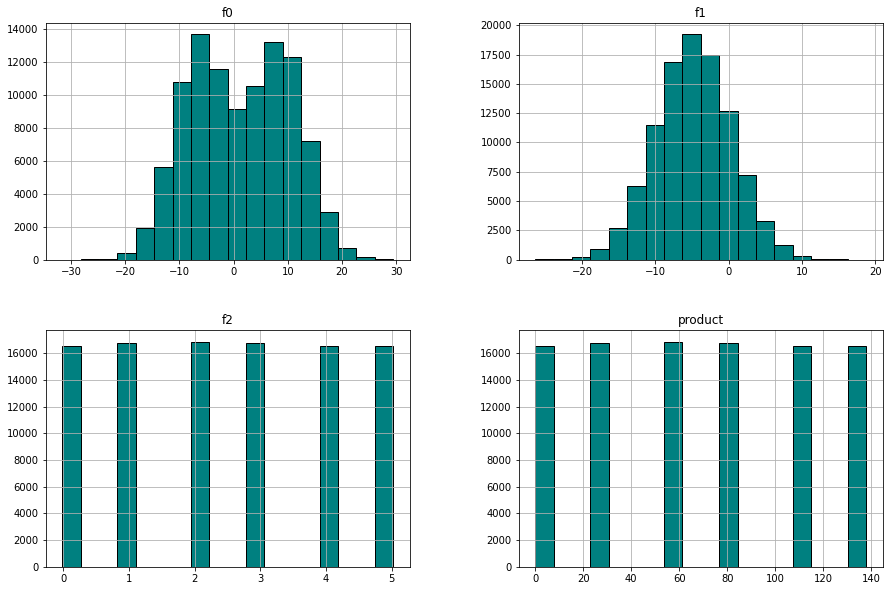

Матрица корреляции:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Тепловая карта:


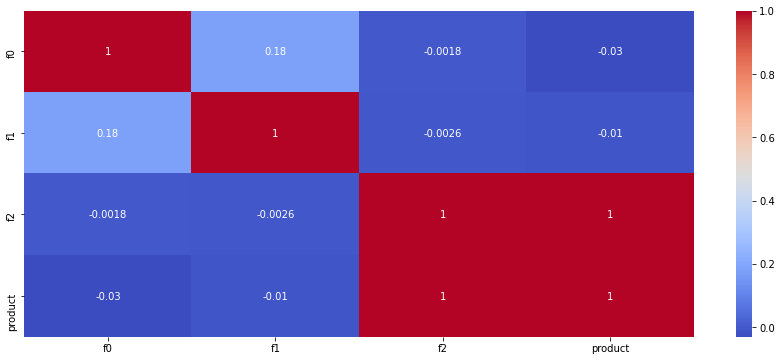

In [10]:
explorer(df_zone_2)

**Вывод**: среднее и медиана признаков не имеют большой разницы, кроме столбца 'product' (в нем же есть разброс значений, который выражен в стандартном отклонении). Имеется высокая связь между признаком 'f2' и 'product', следовательно, в данном регионе объем запасов в скважине зависит только от признака точки 'f2'. Мультиколлинеарности между признаками точек нет.

Посмотрим на **датафрейм df_zone_3** с данными геологоразведки региона 3:

Статистический анализ:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Гистограммы:


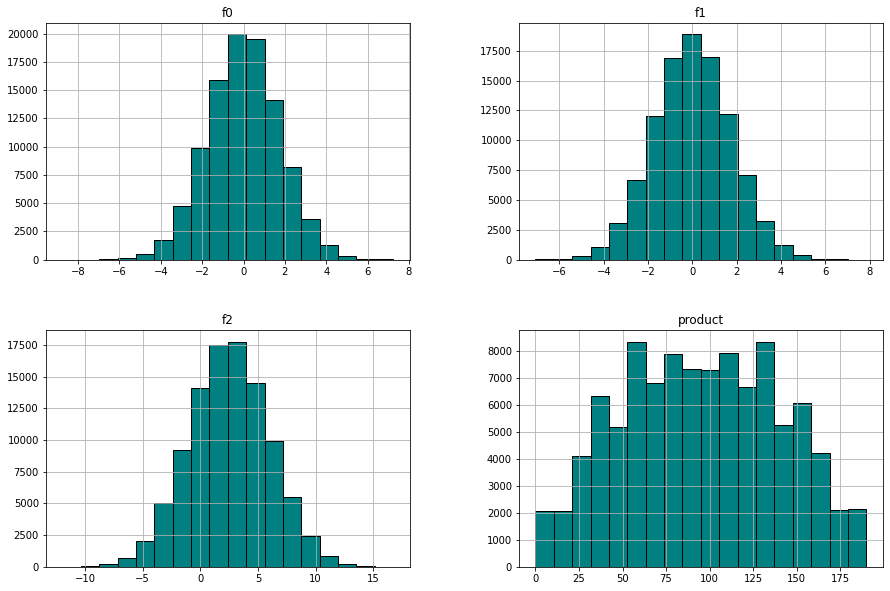

Матрица корреляции:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Тепловая карта:


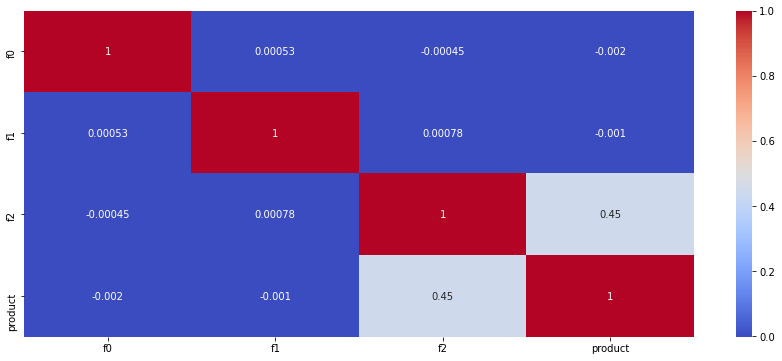

In [11]:
explorer(df_zone_3)

**Вывод**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется умеренная связь между признаком 'f2' и 'product' Мультиколлинеарности между признаками точек нет.

### Подготовка данных

Удалим столбец 'id', он не несет значимости для модели:

In [12]:
df_zone_1 = df_zone_1.drop('id', axis=1)
df_zone_2 = df_zone_2.drop('id', axis=1)
df_zone_3 = df_zone_3.drop('id', axis=1)

# Проверяем изменения
display(df_zone_1.sample())
display(df_zone_2.sample())
display(df_zone_3.sample())

,f0,f1,f2,product
73574,0.173157,0.139823,0.243227,124.799153


,f0,f1,f2,product
8860,-1.030611,-8.661676,0.991581,30.132364


,f0,f1,f2,product
80551,1.846686,0.754642,1.224194,55.68656


**Вывод**: данные готовы к обучению модели. Для обучения модели подходит линейная регрессия.

### Вывод

**На этапе загрузки и подготовки данных было выполнено**:
1. загружены файлы и сохранены в датафреймы по трем регионам геологоразведки (df_zone_1, df_zone_2, df_zone_3);


2. выведена информация о датафремах, вывод:
   - по 10000 строк и 5 столбцов в каждом датафрейме;
   - пропусков нет;
   - названия столбцов записаны корректно, исправлений не требуется;
   - типы данных верные;
   - каждый датафрейм содержит (описание данных):
     - id — уникальный идентификатор скважины;
     - f0, f1, f2 — три признака точек (признаки значимы);
     - product — объём запасов в скважине (тыс. баррелей).


3. проведена предобработка данных:
   - проверка на явные дубликаты - не выявлено;
   - проверка на неявные дубликаты - не выявлено.


4. проведен анализ данных:
   - статистика числовых значений;
   - построены гистограммы;
   - построена матрица корреляции;
   - построена тепловая карта.
   В результате:
     - **df_zone_1**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется связь между признаками прямая и обратная. Мультиколлинеарности нет;
     - **df_zone_2**: среднее и медиана признаков не имеют большой разницы, кроме столбца 'product' (в нем же есть разброс значений, который выражен в стандартном отклонении). Имеется высокая связь между признаком 'f2' и 'product', следовательно, в данном регионе объем запасов в скважине зависит только от признака точки 'f2'. Мультиколлинеарности между признаками точек нет;
     - **df_zone_3**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется умеренная связь между признаком 'f2' и 'product' Мультиколлинеарности между признаками точек нет.
     - продукт (запасы в скважинах) распределен между регионами неравномерно.
     
     
5. подготовка данных:
   - столбец 'id' (идентификатор скважины) удален, он не несет полезной информации для обучения модели.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона. 

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25. Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке. Выведем на экран средний запас фактического и предсказанного моделью сырья, RMSE модели. 

In [13]:
def linear_model(data):
    
    # задаем признаки
    target = data['product']
    features = data.drop('product', axis=1)
    
    # делим на выборки в соотношении 75:25   
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                                  random_state=RANDOM_STATE)
    
    # инициализируем и обучаем модель
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # получаем предсказания
    predict_valid = model.predict(features_valid)
    
    # считаем метрику
    rmse = mean_squared_error(target_valid, predict_valid)**0.5
    
    # считаем средний запас прогнозируемого сырья
    predict_valid_mean = predict_valid.sum() / len(predict_valid)
    
    return target_valid, predict_valid, rmse, predict_valid_mean

Получаем показатели для каждого региона с помощью функции:

In [14]:
target_valid_1, predict_valid_1, rmse_1, predict_valid_mean_1 = linear_model(df_zone_1)
target_valid_2, predict_valid_2, rmse_2, predict_valid_mean_2 = linear_model(df_zone_2)
target_valid_3, predict_valid_3, rmse_3, predict_valid_mean_3 = linear_model(df_zone_3)

print(f'Регион 1: средний запас предсказанного сырья: {predict_valid_mean_1:.2f} тыс. баррелей; RMSE = {rmse_1:.2f}')
print(f'Регион 2: средний запас предсказанного сырья: {predict_valid_mean_2:.2f} тыс. баррелей; RMSE = {rmse_2:.2f}')
print(f'Регион 3: средний запас предсказанного сырья: {predict_valid_mean_3:.2f} тыс. баррелей; RMSE = {rmse_3:.2f}')

Регион 1: средний запас предсказанного сырья: 92.40 тыс. баррелей; RMSE = 37.76
Регион 2: средний запас предсказанного сырья: 68.71 тыс. баррелей; RMSE = 0.89
Регион 3: средний запас предсказанного сырья: 94.77 тыс. баррелей; RMSE = 40.15


**Вывод**: наибольший запас предсказанного сырья у третьей зоны (94.77), на втором месте с небольшой разницей идёт первая зона (92.40), наименьшие запасы у второй зоны (68.71). Но по второй зоне модель работает точнее всего (значение метрики RMSE = 0.89 - чем ближе значение метрики к нулю, тем точнее модель). В первой и третьей зонах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью.

По результатам предсказаний модели линейной регрессии предварительно можно утверждать, что вторая зона является самой предсказуемой, но низкодоходной, а третья - самая доходная, но рискованная.

## Подготовка к расчёту прибыли

По условиям задачи:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Ключевые значения для расчетов сохраним в отдельных константах Python (согласно PEP 8):

In [15]:
# количество скважин при разведке региона
HOLE_COUNT = 500

# количество лучших скважин для разработки
BEST_HOLE_COUNT = 200

# бюджет на разработку скважин в одном регионе
BUDGET_FOR_ZONE = 10*(10**9)

# доход с одного барреля
PROFIT_BARREL = 450

# доход с единицы продукта (единица продукта = 1000 баррелей)
PROFIT_PRODUCT = 450000

Рассчитаем минимальный объем сырья в скважине для безубыточной разработки:

In [16]:
min_volume = BUDGET_FOR_ZONE / BEST_HOLE_COUNT / PROFIT_PRODUCT
print(f'Минимальный объём сырья для безубыточной разработки = {min_volume:.2f} тыс. баррелей (единиц продукта).')

Минимальный объём сырья для безубыточной разработки = 111.11 тыс. баррелей (единиц продукта).


In [17]:
names = ['df_zone_1', 'df_zone_2', 'df_zone_3']
data = [df_zone_1, df_zone_2, df_zone_3]

for name, data in zip(names, data):
    print(f'Средний запас в {name} фактического сырья = {data["product"].mean():.2f} тыс. баррелей.')
    print(f'Доля скважин с объёмом больше мин. порога = {len(data.query("product > @min_volume")) / len(data):.2%}')
    print(f'Количество скважин с объёмом больше мин. порога = {len(data.query("product > @min_volume"))}')
    print()

Средний запас в df_zone_1 фактического сырья = 92.50 тыс. баррелей.
Доля скважин с объёмом больше мин. порога = 36.58%
Количество скважин с объёмом больше мин. порога = 36583

Средний запас в df_zone_2 фактического сырья = 68.83 тыс. баррелей.
Доля скважин с объёмом больше мин. порога = 16.54%
Количество скважин с объёмом больше мин. порога = 16537

Средний запас в df_zone_3 фактического сырья = 95.00 тыс. баррелей.
Доля скважин с объёмом больше мин. порога = 38.18%
Количество скважин с объёмом больше мин. порога = 38178



**Вывод**: минимальный объём сырья для безубыточной разработки = 111.11 тыс. баррелей. Скважин с таким минимальным объемом всего 16.54% во второй зоне разработки, в первой и третьей зонах уже побольше - 36.58% и 38.18% соответственно. Средний запас по каждому региону существенно ниже минимального объема сырья для безубыточной разработки.

## Расчёт прибыли и рисков 

Создаем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели (минус инвестиции):

In [ ]:
def profit(target, prediction):
    
    # выбираем скважины с максимальными значениями предсказаний:
    preds_sorted = pd.Series(prediction).sort_values(ascending=False)
    selected = target[preds_sorted.index][:BEST_HOLE_COUNT]
    
    # суммируем объем сырья
    product = selected.sum()
    
    #считаем прибыль для полученного объема сырья
    revenue = product * PROFIT_PRODUCT
    return (revenue - BUDGET_FOR_ZONE)

Применим технику Bootstrap c 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательную прибыль). Для этого создаем функцию:

In [19]:
def bootstrap_zone(target, prediction):
    
    # используем объект для случайного отбора
    state = np.random.RandomState(12345)
    
    # новый список для оценок из бутстрепа
    values = []
    
    target = pd.Series(target).reset_index(drop=True)
    prediction = pd.Series(prediction).reset_index(drop=True)
    
    for i in range(1000):
        target_subsample = target.sample(n=HOLE_COUNT, replace=True, random_state=state)
        pred_subsample = prediction[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample))
                
    values = pd.Series(values)

    values_mean = int(values.mean())
    
    # находим квантили для 95%-го доверительного интервала
    lower = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    
    # считаем риски
    risk = int(len(values[values < 0]) / len(values) * 100)
    
    return values, values_mean, lower, upper, risk

Посчитаем основные параметры при помощи функции для трех регионов:

In [20]:
values_1, values_mean_1, lower_1, upper_1, risk_1 = bootstrap_zone(target_valid_1, predict_valid_1)
values_2, values_mean_2, lower_2, upper_2, risk_2 = bootstrap_zone(target_valid_2, predict_valid_2)
values_3, values_mean_3, lower_3, upper_3, risk_3 = bootstrap_zone(target_valid_3, predict_valid_3)

Визуализируем распределение прибыли для каждого региона:

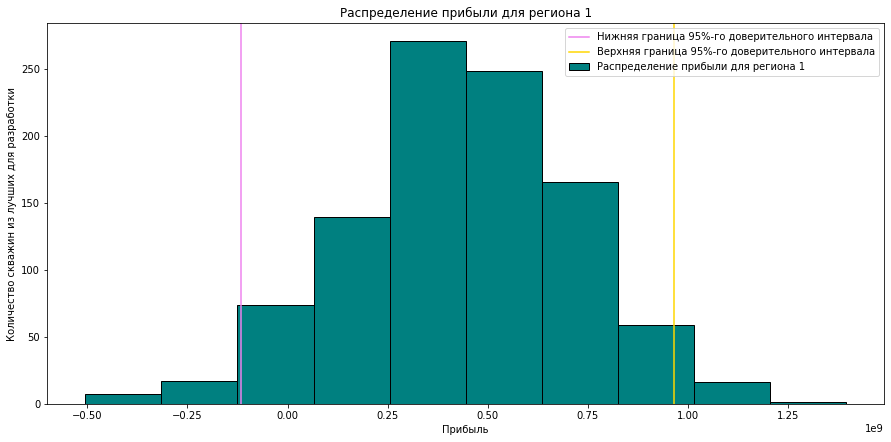

Регион 1: 
Средняя прибыль c 200 лучших скважин для разработки: 43.59 млн
Доверительный интервал: -11.6231612 : 96.650418 млн
Риск убытков: 6% 


In [21]:
values_1.hist(figsize=(15, 7), bins=10, edgecolor='black', color = 'teal')
plt.grid(False)
plt.axvline(lower_1, color='violet')
plt.axvline(upper_1, color='gold')
plt.legend(['Нижняя граница 95%-го доверительного интервала', 'Верхняя граница 95%-го доверительного интервала', 
            'Распределение прибыли для региона 1'])
plt.xlabel('Прибыль')
plt.ylabel('Количество скважин из лучших для разработки')
plt.title('Распределение прибыли для региона 1')
plt.show()

print(f'''Регион 1: 
Средняя прибыль c 200 лучших скважин для разработки: {(values_mean_1 / 10e6):.2f} млн
Доверительный интервал: {lower_1 / 10e6} : {upper_1 / 10e6} млн
Риск убытков: {risk_1}% ''')

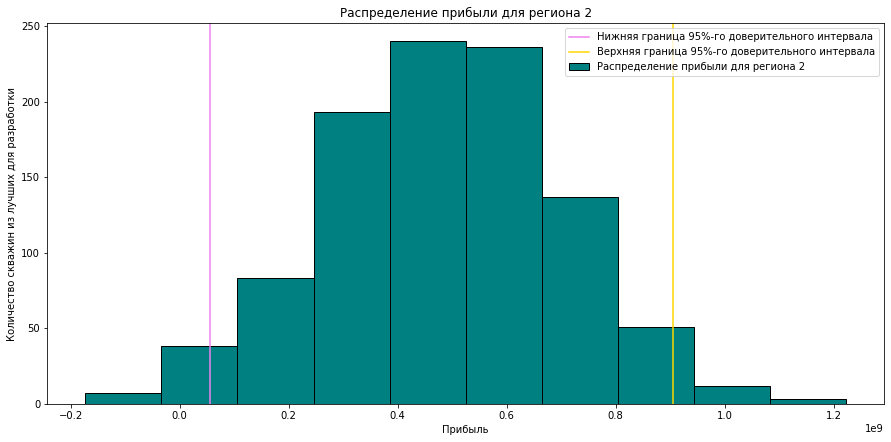

Регион 2: 
Средняя прибыль c 200 лучших скважин для разработки: 48.97 млн
Доверительный интервал: 5.5116177 : 90.576265 млн
Риск убытков: 1% 


In [22]:
values_2.hist(figsize=(15, 7), bins=10, edgecolor='black', color = 'teal')
plt.grid(False)
plt.axvline(lower_2, color='violet')
plt.axvline(upper_2, color='gold')
plt.legend(['Нижняя граница 95%-го доверительного интервала', 
            'Верхняя граница 95%-го доверительного интервала', 
            'Распределение прибыли для региона 2'])
plt.xlabel('Прибыль')
plt.ylabel('Количество скважин из лучших для разработки')
plt.title('Распределение прибыли для региона 2')
plt.show()

print(f'''Регион 2: 
Средняя прибыль c 200 лучших скважин для разработки: {(values_mean_2 / 10e6):.2f} млн
Доверительный интервал: {lower_2 / 10e6} : {upper_2 / 10e6} млн
Риск убытков: {risk_2}% ''')

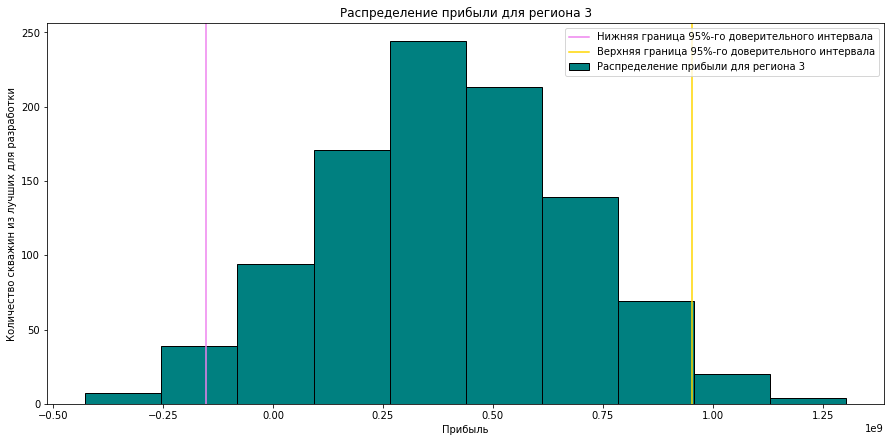

Регион 3: 
Средняя прибыль c 200 лучших скважин для разработки: 40.37 млн
Доверительный интервал: -15.3116984 : 95.2887416 млн
Риск убытков: 7% 


In [23]:
values_3.hist(figsize=(15, 7), bins=10, edgecolor='black', color = 'teal')
plt.grid(False)
plt.axvline(lower_3, color='violet')
plt.axvline(upper_3, color='gold')
plt.legend(['Нижняя граница 95%-го доверительного интервала', 
            'Верхняя граница 95%-го доверительного интервала', 
            'Распределение прибыли для региона 3'])
plt.xlabel('Прибыль')
plt.ylabel('Количество скважин из лучших для разработки')
plt.title('Распределение прибыли для региона 3')
plt.show()

print(f'''Регион 3: 
Средняя прибыль c 200 лучших скважин для разработки: {(values_mean_3 / 10e6):.2f} млн
Доверительный интервал: {lower_3 / 10e6} : {upper_3 / 10e6} млн
Риск убытков: {risk_3}% ''')

**Вывод**: на основании полученных данных можно сделать вывод, что регион 2 является наиболее привлекательным для разработки:
- самая высокая прибыль лучших месторождений (48.97 млн), 
- более узкие рамки доверительного интервала (5.51 : 90.58 млн)
- наименьший риск получения убытков (1%).

Данный регион рекомендован для разработки скважин.

## Общий вывод

- **На этапе загрузки и подготовки данных было выполнено**:
1. загружены файлы и сохранены в датафреймы по трем регионам геологоразведки (df_zone_1, df_zone_2, df_zone_3);

2. выведена информация о датафремах, вывод:
   - по 10000 строк и 5 столбцов в каждом датафрейме;
   - пропусков нет;
   - названия столбцов записаны корректно, исправлений не требуется;
   - типы данных верные;
   - каждый датафрейм содержит (описание данных):
     - id — уникальный идентификатор скважины;
     - f0, f1, f2 — три признака точек (признаки значимы);
     - product — объём запасов в скважине (тыс. баррелей).


3. проведена предобработка данных:
   - проверка на явные дубликаты - не выявлено;
   - проверка на неявные дубликаты - не выявлено.


4. проведен анализ данных:
   - статистика числовых значений;
   - построены гистограммы;
   - построена матрица корреляции;
   - построена тепловая карта.
   В результате:
     - **df_zone_1**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется связь между признаками прямая и обратная. Мультиколлинеарности нет;
     - **df_zone_2**: среднее и медиана признаков не имеют большой разницы, кроме столбца 'product' (в нем же есть разброс значений, который выражен в стандартном отклонении). Имеется высокая связь между признаком 'f2' и 'product', следовательно, в данном регионе объем запасов в скважине зависит только от признака точки 'f2'. Мультиколлинеарности между признаками точек нет;
     - **df_zone_3**: среднее и медиана не имеют большой разницы, в столбце 'product' есть разброс значений, который выражен в стандартном отклонении. Имеется умеренная связь между признаком 'f2' и 'product' Мультиколлинеарности между признаками точек нет.
     - продукт (запасы в скважинах) распределен между регионами неравномерно.
     
     
5. подготовка данных:
   - столбец 'id' (идентификатор скважины) удален, он не несет полезной информации для обучения модели.
   
- **На этапе обучения и проверки модели было выполнено**:
1. Разделены данные на обучающую и валидационную выборки в соотношении 75:25. 

2. Обучена модель линейной регрессии и сделаны предсказания на валидационной выборке. 

3. Рассчитан средний запас фактического и предсказанного моделью сырья, RMSE модели.

**Результат**: наибольший запас предсказанного сырья у третьей зоны (94.77), на втором месте с небольшой разницей идёт первая зона (92.40), наименьшие запасы у второй зоны (68.71). Но по второй зоне модель работает точнее всего (значение метрики RMSE = 0.89 - чем ближе значение метрики к нулю, тем точнее модель). В первой и третьей зонах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью.

По результатам предсказаний модели линейной регрессии предварительно можно утверждать, что вторая зона является самой предсказуемой, но низкодоходной, а третья - самая доходная, но рискованная.

- **На этапе подготовки к расчету прибыли было выполнено**:

1. Ключевые значения для расчетов сохранены в отдельных константах Python (согласно PEP 8) - взяты из условия задачи.

2. Рассчитан минимальный объем сырья в скважине для безубыточной разработки: 111.11 тыс. баррелей (единиц продукта).

3. Рассчитаны средние запасы в скважинах по каждому региону, проведено сравнение с минимальным объемом сырья для безубыточной разработки. 

**Результат**: скважин с минимальным объемом сырья для безубыточной разработки всего 16.54% во второй зоне разработки, в первой и третьей зонах побольше - 36.58% и 38.18% соответственно. Средний запас по каждому региону существенно ниже минимального объема сырья для безубыточной разработки.

- **На этапе расчета прибыли и рисков было выполнено**:

1. Создана функция для расчета прибыли по выбранным скважинам и предсказаниям модели (минус инвестиции).

2. Применена техника Bootstrap c 1000 выборок, чтобы найти распределение прибыли. Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков (отрицательная прибыль). Для этого создана функция. 

3. Рассчитаны основные параметры при помощи функций для трех регионов. 

4. Визуализировано распределение прибыли для каждого региона.

**Результат**:
- Регион 1: 
  - Средняя прибыль c 200 лучших скважин для разработки: 43.59 млн
  - Доверительный интервал: -11.6231612 : 96.650418 млн
  - Риск убытков: 6% 

- Регион 2: 
  - Средняя прибыль c 200 лучших скважин для разработки: 48.97 млн
  - Доверительный интервал: 5.5116177 : 90.576265 млн
  - Риск убытков: 1% 

- Регион 3: 
  - Средняя прибыль c 200 лучших скважин для разработки: 40.37 млн
  - Доверительный интервал: -15.3116984 : 95.2887416 млн
  - Риск убытков: 7% 
  

**Окончательный вывод**: 

На основании полученных данных можно сделать вывод, что **регион 2 является наиболее привлекательным для разработки**:
- самая высокая прибыль лучших месторождений (48.97 млн), 
- более узкие рамки доверительного интервала (5.51 : 90.58 млн)
- наименьший риск получения убытков (1%).

**Данный регион рекомендован для разработки скважин.**